In [1]:
%load_ext autotime

import pandas as pd
import numpy as np
import scarf
from tqdm.auto import tqdm
from joblib import Parallel, delayed
from glob import glob
import pathlib
from scarf.utils import tqdmbar, controlled_compute
from numba import jit
from scarf.writers import create_zarr_count_assay
scarf.__version__

'0.20.0'

time: 1.42 s (started: 2022-08-13 15:11:59 +02:00)


In [2]:
scarf.fetch_dataset('motifs', save_path='../scarf_datasets/')

time: 13.6 s (started: 2022-08-13 15:12:00 +02:00)


In [3]:
ds = scarf.DataStore('../scarf_datasets/tenx_10K_pbmc-v1_atacseq/data.zarr', nthreads=4)

time: 63 ms (started: 2022-01-04 06:57:42 +01:00)


In [6]:
def check_if_overlap(a, b):
    a = a.sort_values(by=[0, 1]).copy()
    b = b.sort_values(by=[0, 1]).copy()

    does_overlap = np.zeros(a.shape[0]).astype(bool)
    chroms = sorted(a[0].unique())[::-1]
    for chrom in tqdm(chroms):
        a_c = a[0] == chrom
        b_c = b[0] == chrom
        if b_c.sum() == 0:
            continue

        ra = a[a_c.values][[1,2]].values.astype(int)
        rb = b[b_c.values][[1,2]].values.astype(int)
        o = scarf.meld_assay.binary_search(rb, ra)

        idx = o[:, 0] != -1
        does_overlap[a_c[a_c][idx].index] = True
    return does_overlap

time: 0 ns (started: 2022-01-04 06:57:53 +01:00)


In [7]:
peaks_bed = scarf.meld_assay.create_bed_from_coord_ids(ds.ATAC.feats.fetch_all('ids'))
genes = pd.read_csv(
    '../scarf_datasets/annotations/human_GRCh37_gencode_v38_gene_body.bed.gz',
    sep='\t',
    header=None
)
genic_peaks = check_if_overlap(peaks_bed, genes)

  0%|          | 0/24 [00:00<?, ?it/s]

time: 766 ms (started: 2022-01-04 06:57:54 +01:00)


In [18]:
distal_peaks = peaks_bed[~genic_peaks].reset_index(drop=True)

time: 0 ns (started: 2022-01-04 07:00:37 +01:00)


In [19]:
def get_mapping(fn):
    tf_bed = pd.read_csv(fn, sep='\t', header=None)
    return np.where(check_if_overlap(distal_peaks, tf_bed))[0]

fns = sorted(glob('../scarf_datasets/motifs/hg1910k_cleaned/*.bed'))
ids_names = [str(pathlib.Path(x).name).split('.bed')[0] for x in fns ]

tf_to_peak = Parallel(n_jobs=4)(
    delayed(get_mapping)(i) for i in tqdm(fns)
)

  0%|          | 0/746 [00:00<?, ?it/s]

time: 31.2 s (started: 2022-01-04 07:00:50 +01:00)


In [20]:
assay = ds.ATAC
g = create_zarr_count_assay(
    z=assay.z["/"],
    assay_name='MOTIFS',
    chunk_size=assay.rawData.chunksize,
    n_cells=assay.rawData.shape[0],
    feat_ids=[x.rsplit('_', 1)[0] for x in ids_names],
    feat_names=[x.rsplit('_', 1)[1] for x in ids_names],
    dtype="float",
)

time: 125 ms (started: 2022-01-04 07:01:34 +01:00)


In [21]:
non_genic_peaks = np.where(genic_peaks == False)[0]
tf_to_distal_peak = []
distal_peak_set = []
full_peak_set = []
for i in tf_to_peak:
    full_peak_set.extend(list(i))
    i = sorted(set(i).intersection(non_genic_peaks))
    tf_to_distal_peak.append(i)
    distal_peak_set.extend(i)
distal_peak_set = sorted(set(distal_peak_set))
full_peak_set = sorted(set(full_peak_set))
len(distal_peak_set), len(full_peak_set)

(3338, 14682)

time: 906 ms (started: 2022-01-04 07:01:35 +01:00)


In [93]:
n_docs = ds.cells.N
n_cells = assay.feats.fetch_all("nCells")
idf = np.log2(n_docs / (n_cells + 1))

s = 0
for a in tqdmbar(assay.rawData.blocks, total=assay.rawData.numblocks[0]):
    a = controlled_compute(a, assay.nthreads)
    temp = []
    
    b = a[:, distal_peak_set].copy()
    b[b>0] = 1
    ntpd = b.sum(axis=1) + 1
        
    for fidx in tf_to_distal_peak:
        tfidf = (a[:, fidx] / ntpd.reshape(-1, 1)) * idf[fidx]
        
        temp.append(tfidf.mean(axis=1))
    
    e = s + a.shape[0]
    g[s:e] = np.array(temp).T 
    s = e

  0%|                                                                                                         …

time: 13.2 s (started: 2021-08-27 19:35:22 +02:00)


In [99]:
ds = scarf.DataStore('../scarf_datasets/tenx_10K_pbmc-v1_atacseq/data.zarr',
                     nthreads=4, assay_types={'MOTIFS': 'RNA'})

(MOTIFS) Computing MOTIFS_percentMito:   0%|                                                                  …

time: 219 ms (started: 2021-08-27 19:36:21 +02:00)


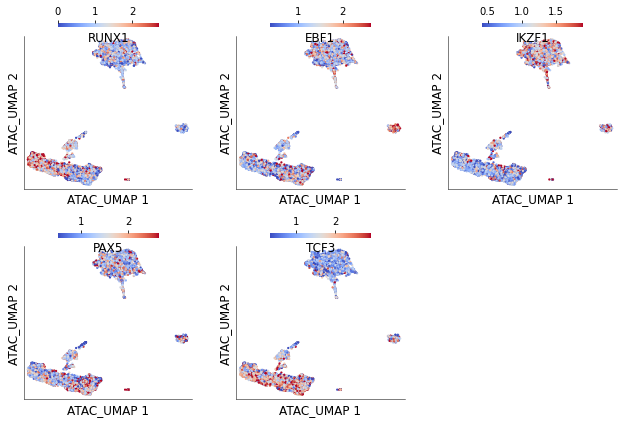

time: 3.66 s (started: 2021-08-27 19:36:24 +02:00)


In [100]:
ds.plot_layout(
    layout_key='ATAC_UMAP', from_assay='MOTIFS', 
    color_by=['RUNX1', 'EBF1', 'IKZF1', 'PAX5','TCF3'],
    clip_fraction=0.05, n_columns=3,
    width=3, height=3, point_size=5,
    scatter_kwargs={'lw': 0.01}, cmap='coolwarm',
)

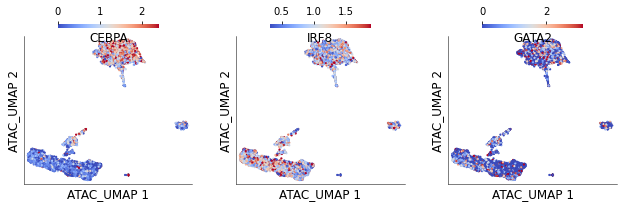

time: 2.16 s (started: 2021-08-27 19:36:28 +02:00)


In [101]:
ds.plot_layout(
    layout_key='ATAC_UMAP', from_assay='MOTIFS', 
    color_by=['CEBPA', 'IRF8', 'GATA2'],
    clip_fraction=0.05, n_columns=3,
    width=3, height=3, point_size=5,
    scatter_kwargs={'lw': 0.01}, cmap='coolwarm',
)

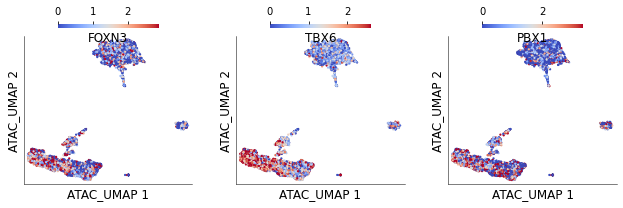

time: 2.17 s (started: 2021-08-27 19:39:47 +02:00)


In [113]:
ds.plot_layout(
    layout_key='ATAC_UMAP', from_assay='MOTIFS', 
    color_by=['FOXN3', 'TBX6', 'PBX1'],
    clip_fraction=0.1, n_columns=3,
    width=3, height=3, point_size=5,
    scatter_kwargs={'lw': 0.01}, cmap='coolwarm',
)

In [102]:
ds.run_marker_search(group_key='ATAC_leiden_cluster', from_assay='MOTIFS', threshold=0.1)

Finding markers:   0%|                                                                                        …

time: 3.23 s (started: 2021-08-27 19:37:00 +02:00)


In [112]:
ds.get_markers(group_key='ATAC_leiden_cluster', from_assay='MOTIFS', group_id=3).head(n=10)

,score,names
597,0.203994,FOXN3
669,0.198316,TBX6
46,0.197207,PBX1
667,0.190052,TBX18
292,0.182102,TBX21
307,0.180010,Lhx8
402,0.178426,EOMES
291,0.178024,TBX20
404,0.176609,TBR1
668,0.175694,TBX3


time: 31 ms (started: 2021-08-27 19:39:30 +02:00)


In [103]:
ds.make_graph(from_assay='MOTIFS', feat_key='I')

Normalizing with feature subset:   0%|                                                                        …

Writing data to normed__I__I/data:   0%|                                                                      …

Calculating mean of norm. data:   0%|                                                                         …

Calculating std. dev. of norm. data:   0%|                                                                    …

Fitting PCA:   0%|                                                                                            …

Fitting ANN:   0%|                                                                                            …

Fitting kmeans:   0%|                                                                                         …

Estimating seed partitions:   0%|                                                                             …

Saving KNN graph:   0%|                                                                                       …

Smoothening KNN distances:   0%|                                                                              …

INFO: ANN recall: 99.99%
time: 7.52 s (started: 2021-08-27 19:37:06 +02:00)


In [104]:
ds.run_umap(from_assay='MOTIFS')

	completed  0  /  300 epochs
	completed  30  /  300 epochs
	completed  60  /  300 epochs
	completed  90  /  300 epochs
	completed  120  /  300 epochs
	completed  150  /  300 epochs
	completed  180  /  300 epochs
	completed  210  /  300 epochs
	completed  240  /  300 epochs
	completed  270  /  300 epochs
time: 7.95 s (started: 2021-08-27 19:37:14 +02:00)


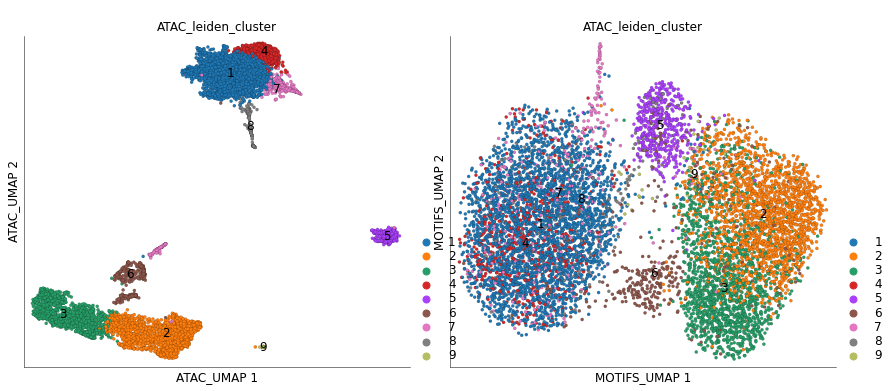

time: 703 ms (started: 2021-08-27 19:37:22 +02:00)


In [105]:
ds.plot_layout(layout_key=['ATAC_UMAP', 'MOTIFS_UMAP'], color_by='ATAC_leiden_cluster')

In [106]:
ds.show_zarr_tree()

/
 ├── ATAC
 │   ├── counts (8728, 89796) uint32
 │   ├── featureData
 │   │   ├── I (89796,) bool
 │   │   ├── I__prevalent_peaks (89796,) bool
 │   │   ├── dropOuts (89796,) int32
 │   │   ├── ids (89796,) <U25
 │   │   ├── nCells (89796,) int32
 │   │   └── names (89796,) <U25
 │   ├── normed__I__prevalent_peaks
 │   │   ├── data (8426, 25000) float64
 │   │   └── reduction__lsi__50__I
 │   │       ├── ann__l2__63__63__64__4466
 │   │       │   └── knn__21
 │   │       │       ├── distances (8426, 21) float64
 │   │       │       ├── graph__1.0__1.5
 │   │       │       │   ├── edges (176946, 2) uint64
 │   │       │       │   └── weights (176946,) float64
 │   │       │       └── indices (8426, 21) uint64
 │   │       ├── kmeans__100__4466
 │   │       │   ├── cluster_centers (100, 50) float64
 │   │       │   └── cluster_labels (8426,) float64
 │   │       └── reduction (25000, 50) float64
 │   └── summary_stats_I
 │       └── prevalence (89796,) float64
 ├── GeneScores
 │   ├── c

In [ ]:
# for i in ['body']:
#     for j in ['v38', 'v38lift37', 'vM25', 'vM27']:
#         gff_reader = scarf.GffReader(f"../scarf_datasets/gencode.{j}.annotation.gff3.gz", up_offset=2000)
#         gff_reader.to_bed(f"../scarf_datasets/annotations/gencode_{j}_gene_{i}.bed.gz", flavour=i)

In [ ]:
# def make_coords_to_bed(chroms_se, starts):
#     chroms = [f"chr{x}" for x in range(1, 23)] + ['chrX', 'chrY']
#     bed = []
#     for chrom_n in range(len(chroms)):
#         s,e = chroms_se[chrom_n]
#         if s == -1:
#             continue
#         pos = starts[s:e]
#         temp = pd.DataFrame([
#             [chroms[chrom_n] for _ in range(pos.shape[0])],
#             pos,
#             pos+10,
#         ])
#         bed.append(temp.T)
#     return pd.concat(bed).reset_index(drop=True).sort_values(by=[0, 1])

# def get_mapping(chroms_se, starts):
#     tf_bed = make_coords_to_bed(chroms_se, starts)
#     return np.where(check_if_overlap(peaks_bed, tf_bed))[0]

# mstarts = np.load('../scarf_datasets/motifs/human_hg19_top10K_jaspar2020ucsc/starts.npz')['arr_0']
# mchroms = np.load('../scarf_datasets/motifs/human_hg19_top10K_jaspar2020ucsc/chroms.npz')['arr_0']

# tf_to_peak = Parallel(n_jobs=4)(
#     delayed(get_mapping)(mchroms[i], mstarts[i])
#     for i in tqdm(range(mstarts.shape[0]))
# )

# ids_names = pd.read_csv(
#     '../scarf_datasets/motifs/human_hg19_top10K_jaspar2020ucsc/names.txt', header=None)[0]

In [5]:
# cross_matches = binary_search(
#         np.array([[0, 2], [5, 9], [8, 10], [15, 20], [21,22]]),
#         np.array([[1,2], [1, 25], [2, 4], [3, 4], [3, 5], [5, 8], [5,9], [6,7], [12, 13],
#                   [12, 14], [16, 17], [30, 40]]),
#     )
# cross_matches

time: 0 ns (started: 2021-08-22 18:45:37 +02:00)
